In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare data

In [3]:
coarse_factors = [32]
Directory = f"data"
variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

full_len_in = nz*(len(variables)-1)
len_in = nz

model_number = 11
tmin=1
tmax=62+1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print('using cuda : ', torch.cuda.is_available())

path_times_train = f'data/test_train_times/times_train_{model_number}.csv'
path_times_test = f'data/test_train_times/times_test_{model_number}.csv'
isFile = os.path.isfile(path_times_train) and os.path.isfile(path_times_test)
#print(isFile)

if not isFile :
    utils.split_times(tmin,tmax,model_number)
    
train_times = pd.read_csv(path_times_train).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(path_times_test).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

_, _, input_test, _ = utils.make_train_test_ds(coarse_factors, full_len_in, train_times, test_times, Directory)
input_test = input_test.reshape(-1,len(variables)-1,nz)

for i in range(len(variables)-1):
    input_test[:,i] -= torch.mean(input_test[:,i])
    input_test[:,i] /= torch.std(input_test[:,i])

In [4]:
input_U = input_test[:,0]
input_V = input_test[:,1]
input_W = input_test[:,2]
input_Theta = input_test[:,3]
input_S = input_test[:,4]
input_TKE = input_test[:,5]

input_U.shape

torch.Size([3328, 376])

In [5]:
z=150

hori_U = input_test[:,0]
l = int(np.sqrt(hori_U.shape[0]/test_times.shape[0]))
hori_U = hori_U[:l**2].reshape(l,l,-1)

hori_V = input_test[:l**2,1].reshape(l,l,-1)
hori_W = input_test[:l**2,2].reshape(l,l,-1)
hori_Thta = input_test[:l**2,3].reshape(l,l,-1)
hori_S = input_test[:l**2,4].reshape(l,l,-1)
hori_TKE = input_test[:l**2,5].reshape(l,l,-1)

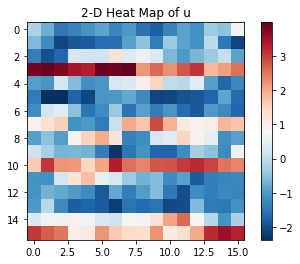

In [6]:
im = plt.imshow(hori_W[:,:,z])
im = plt.imshow(hori_W[:,:,z] , cmap = 'RdBu_r' , interpolation = 'nearest' )
plt.colorbar(im)
plt.title(f"2-D Heat Map of u")
plt.show()

Turbulence on ligne 4 : between the 49th and 64th samples

Check variance vertically for these samples and for samples on ligne 1 (between 1st and 16th samples).

Check variance horizontally for square around turbulent cell

In [7]:
print('vertical variance in turbulent zone :', input_W[50,:].numpy().var(),',', input_W[55,:].numpy().var(),',', input_W[60,:].numpy().var())
print('vertical variance in laminar zone :', input_W[0,:].numpy().var(),',', input_W[5,:].numpy().var(),',', input_W[10,:].numpy().var())

vertical variance in turbulent zone : 2.218759 , 1.8950505 , 1.2108034
vertical variance in laminar zone : 0.04957265 , 0.2165661 , 0.23964939


In [8]:
print(hori_W[0:5,1:6,z].shape)
#Attention, les axes x et y sont inversés
print('horizontal variance in turbulent zone :', hori_W[2:5,0:3,z].numpy().var(),',', hori_W[2:5,5:9,z].numpy().var())
print('horizontal variance in laminar zone :', hori_W[0:3,0:3,z].numpy().var(),',', hori_W[0:3,5:9,z].numpy().var())


torch.Size([5, 5])
horizontal variance in turbulent zone : 5.880849 , 2.6521287
horizontal variance in laminar zone : 0.36272424 , 0.8623388
